In [1]:
import pandas as pd
import os
import numpy as np

## TRAIN

In [2]:
tag = 'train'
read_path = os.path.abspath('')+f'\\__pycache__\\{tag}_pixel_dataframe.csv'
pixels_df = pd.read_csv(read_path, index_col=0)

In [3]:
pixels_df.head()

,neighbor_average,proc_phantom_pixel_values,pixel_real_value
0,0.940748,2.101830,True
1,1.026745,1.496298,True
2,0.944519,0.769860,True
3,0.632857,1.341718,True
4,1.004393,1.091691,True


In [4]:
X_train = np.asarray(pixels_df[['neighbor_average', 'proc_phantom_pixel_values']])
X_train[0:5]

array([[0.94074825, 2.10183043],
       [1.0267446 , 1.49629813],
       [0.9445192 , 0.76985979],
       [0.63285668, 1.34171823],
       [1.00439272, 1.09169119]])

In [5]:
Y_train = np.asarray(pixels_df['pixel_real_value'])
Y_train[0:5]

array([ True,  True,  True,  True,  True])

In [6]:
from sklearn import preprocessing
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train)
X_train[0:5]

array([[-0.2572107 ,  1.35819675],
       [-0.01200743,  0.59014615],
       [-0.24645851, -0.33126037],
       [-1.1351087 ,  0.39407868],
       [-0.07573984,  0.07694709]])

## TEST

In [7]:
tag = 'test'
read_path = os.path.abspath('')+f'\\__pycache__\\{tag}_pixel_dataframe.csv'
pixels_df = pd.read_csv(read_path, index_col=0)

In [8]:
pixels_df.head()

,neighbor_average,proc_phantom_pixel_values,pixel_real_value
0,0.677038,0.685726,False
1,0.610746,1.127324,False
2,0.721371,0.752467,False
3,0.619321,0.578994,False
4,0.416714,0.939275,False


In [9]:
pixels_df.shape
pixels_df.columns

Index(['neighbor_average', 'proc_phantom_pixel_values', 'pixel_real_value'], dtype='object')

In [10]:
X_test = np.asarray(pixels_df[['neighbor_average', 'proc_phantom_pixel_values']])
X_test[0:5]

array([[0.67703811, 0.68572589],
       [0.61074639, 1.12732387],
       [0.72137097, 0.75246738],
       [0.61932059, 0.57899421],
       [0.41671377, 0.93927525]])

In [11]:
Y_test = np.asarray(pixels_df['pixel_real_value'])
Y_test[0:5]

array([False, False, False, False, False])

In [12]:
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test)
X_test[0:5]

array([[-1.05267887, -0.45215657],
       [-1.24035442,  0.09774669],
       [-0.92717008, -0.36904622],
       [-1.21608036, -0.585065  ],
       [-1.78967156, -0.1364223 ]])

<h2 id="modeling">Modeling (Logistic Regression with Scikit-learn)</h2>

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
LR = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, Y_train)

Prediction:

In [14]:
yhat = LR.predict(X_test)
print(len(yhat))
print(len(X_test))

248004
248004


In [15]:
from sklearn.metrics import jaccard_similarity_score
jaccard_similarity_score(Y_test, yhat)

0.7582861566748923

## Making 2d image

In [16]:
a = np.asarray([1,2,3,4,5,6,7,8,9])

In [17]:
import matplotlib.pyplot as plt

In [18]:
def to_img(lin_arr):
    _, ax = plt.subplots(figsize = (7,7))
    size = int(round(np.sqrt(len(lin_arr))))
    img = lin_arr.reshape((size, size))
    ax.imshow(img, cmap = 'gray')

Original img

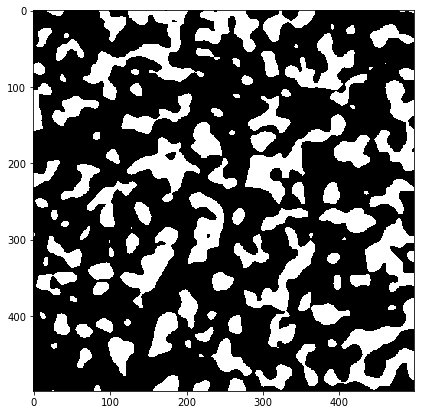

In [19]:
to_img(Y_test)

Binarized img

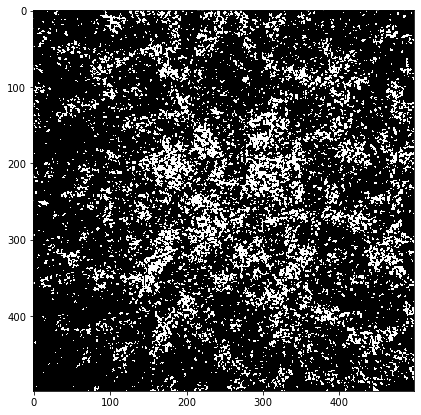

In [20]:
to_img(yhat)

In [21]:
np.sqrt(248004)

498.0